In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from datetime import datetime

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Fire Emblem Heroes: Predicting Tiers for Current and New Characters

For many people who play gacha games, there comes a time where the player accumulates a boatload amount of items (for this game: orbs) that can be used to roll for characters. For those who are FTP (free to play), every orb is precious, because accumulating enough to roll, let alone to accumulate enough to have a shot at a character that they want, takes time

Most players are influenced by two factors when rolling for characters: whether they like the character, and whether the character is good in the game.

Because the first factor is purely subjective, we would like to address the second factor: What makes a character good? A place that I often look to when trying to see how good a character is, is Gamepress.gg, particularly the [tier list](https://gamepress.gg/feheroes/offense-tier-list).

In this notebook, we will go through the process of creating a model to predict what tier characters fall under. This will help give us a better idea of whether a character is "good" or not.

To start we will load the dataset we scraped previously (refer to the Fire Emblem Heroes Scraping and Visualization Notebook to see process)

In [117]:
#tiers = pd.read_excel("tier_list_110719.xlsx")
heroes = pd.read_excel("hero_data.xlsx")

In [119]:
heroes.head()

,Name,Tier,Color,Weapon,MoveType,Rarities,HP,Atk,Spd,Def,Res,Total,Refines,Personal Weapon,Legendary/Mythic,Origin,Refresher,Stars,Obtain
0,Abel,Tier 4,Blue,Lance,Cavalry,stars-3-4,39,33,32,25,25,154,True,False,False,Fire Emblem: Mystery of the Emblem,False,"['3', '4']",NaN
1,Adrift Camilla,Tier 3,Red,Tome,Flying,stars-5-Star,36,37,30,17,30,150,False,True,False,Fire Emblem Heroes,False,['5'],NaN
2,Adrift Corrin (F),Tier 2,Green,Dragon,Infantry,stars-5-Star,41,31,37,32,27,168,False,True,False,Fire Emblem Fates,False,['5'],NaN
3,Adrift Corrin (M),Tier 2,Blue,Dragon,Infantry,stars-5-Star,42,35,35,31,24,167,False,True,False,Fire Emblem Fates,False,['5'],NaN
4,Alfonse,Tier 4,Red,Sword,Infantry,stars-4_Star_Story,43,35,25,32,22,157,True,True,False,Fire Emblem Heroes,False,['4'],Story


## Feature Engineering

Now that we have our data, let's make the most of it. It is an important skill to be able to garner as much "useful" information from a dataset as possible, as well as making it easy for your model to use.

### Seasonal Banners

We notice that, looking at the characters, that there are a good number of seasonal banners that bring with them limitedly-available characters. For collectors, these would be banners that they would dump orbs on. But it's possible that some seasons are superior to others in terms of characters.

In [127]:
def seasonal_label(row):
    if row["Name"].startswith("Summer"):
        return "Summer"
    elif row["Name"].startswith("Spring"):
        return "Spring"
    elif row["Name"].startswith("Halloween"):
        return "Halloween"
    elif row["Name"].startswith("Winter"):
        return "Winter"
    elif row["Name"].startswith("Brave"):
        return "Brave"
    elif row["Name"].startswith("New Year"):
        return "New Year"
    else:
        return None

In [128]:
heroes["Special Banner"] = heroes.apply(lambda row: seasonal_label(row), axis=1)

### Rarities

We will also separate the information related to the rarity of a character into different columns

In [129]:
rare3 = []
rare4 = []
rare5 = []
for rare in heroes["Stars"]:
    if '3' in rare:
        rare3.append(1)
    else:
        rare3.append(0)
    if '4' in rare:
        rare4.append(1)
    else:
        rare4.append(0)
    if '5' in rare:
        rare5.append(1)
    else:
        rare5.append(0)

heroes["3-star"] = rare3
heroes["4-star"] = rare4
heroes["5-star"] = rare5

### One-Hot Encoding and Selecting Our Features

An important thing to deal with before feeding your data into your model is to think about how the model takes in the data. To help with the model's prediction, we will take the categorical variables and go through a process called "one-hot encoding", which takes each value in a categorial variable and makes a new variable that indicates whether the character has that attribute or not. 

We can see that doing this will noticeably increase the number of variables for our model.

In [245]:
data = pd.get_dummies(heroes, prefix = ["Obtain", "Legendary/Mythic", "Color", "Weapon", "Move", 
                         "Refresher", "Refines", "Special Banner", "Personal"], 
               columns = ["Obtain", "Legendary/Mythic", "Color", "Weapon", "MoveType",
                         "Refresher", "Refines", "Special Banner", "Personal Weapon"])

#with pd.option_context('display.max_rows', 5, 'display.max_columns', 100):
#    display(data)

In [232]:
print("Number of Features in Original Data Set", len(pd.read_excel("hero_data.xlsx").columns))
print("Number of Features in Updated Data Set", len(data.columns))

Number of Features in Original Data Set 19
Number of Features in Updated Data Set 49


For this next step, we will choose which variables to feed to our model. For the time being, we will choose to exclude features that are mostly redundant, as well as the origin of the characters.

In [144]:
data2 = data.drop(["Origin", "Rarities", "Total", "Personal_False", "Refines_False",
                   "Legendary/Mythic_False", "Stars", "Refresher_False"], axis = 1)

## Model Testing

At this point, now that we have decided on our features, we will begin to train the model. We will begin by randomizing our data so that ordering by name does not confound the results of our model.

Afterwards, we will split the data into two parts: training and testing data. We do a ~80/20 split.

In [212]:
totest = data2[data2["Tier"].isnull()]

In [145]:
totest = data2[data2["Tier"].isnull()]
data3 = data2[data2["Tier"].notnull()].sample(frac=1)
data3 = data3.set_index("Name")

In [146]:
len(data3)
len(totest)

18

In [147]:
train = data3[:350]
test = data3[350:]

In [148]:
train_y = train["Tier"]
train_x = train.drop(["Tier"], axis = 1)
test_y = test["Tier"]
test_x = test.drop(["Tier"], axis = 1)

For the choice of our model, we have many options that we can go with. To begin our analysis, we will use the DecisionTreeClassifier model.

In [149]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(train_x, train_y)
score = clf.score(test_x, test_y)
print("Train Score:", clf.score(train_x, train_y))
print("Test Score:", score)

Train Score: 0.7171428571428572
Test Score: 0.4117647058823529


In [246]:
# allows one to see the impact each variable has on the model's prediction
#for i in range(len(train_x.columns)):
#    print(train_x.columns[i], clf.feature_importances_[i])

In [151]:
def get_heatmap(model, features, label):
    pred = {'y_Predicted': model.predict(features),
        'y_Actual': label.values
        }
    pred_df = pd.DataFrame(pred, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(pred_df['y_Actual'], pred_df['y_Predicted'], 
                                rownames=['Actual'], colnames=['Predicted'], margins = True)

    sns.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.title("Training Data Heatmap")
    plt.show()

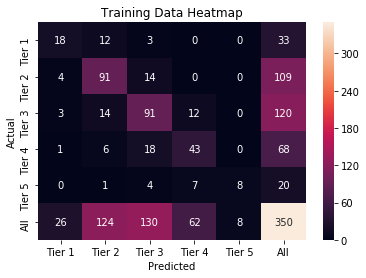

In [152]:
get_heatmap(clf, train_x, train_y)

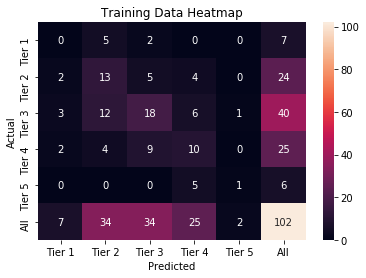

In [153]:
get_heatmap(clf, test_x, test_y)

## What Could We Do Better?

From the initial results above, we can see that our model does a decent job at predicting the tier that a character will be in. However, there are still ways that we could improve our model's capacity to predict how good a character is deemed.

(Granted, Tier lists are somewhat subjective. Thus, it is possible that what a model believes to be a "Tier 1" character doesn't align with the tier-list maker's views. Also, as of now, there is information that may be lacking)

### Rescaling Data

One avenue to look at is with the way our data is fed into the model. Some models are sensitive to feature scaling. To avoid this issue, there are two common ways to adjust the quantitative values of our data.

#### Normalization

In [154]:
from sklearn import preprocessing

In [156]:
norm = data3.copy()
scale_cols = ["HP", "Atk", "Spd", "Def", "Res"]
normed = preprocessing.normalize(norm[scale_cols])

norm[scale_cols] = normed

ntrain = norm[:350]
ntest = norm[350:]
ntrain_y = ntrain["Tier"]
ntrain_x = ntrain.drop(["Tier"], axis = 1)
ntest_y = ntest["Tier"]
ntest_x = ntest.drop(["Tier"], axis = 1)


nclf = DecisionTreeClassifier(max_depth=7)
nclf.fit(ntrain_x, ntrain_y)
nscore = nclf.score(ntest_x, ntest_y)
print("Train Score:", nclf.score(ntrain_x, ntrain_y))
print("Test Score:", nscore)

Train Score: 0.7657142857142857
Test Score: 0.4215686274509804


In [157]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(ntrain_x, ntrain_y)
kscore = neigh.score(ntest_x, ntest_y)
print("Train Score:", neigh.score(ntrain_x, ntrain_y))
print("Test Score:", kscore)

Train Score: 0.5114285714285715
Test Score: 0.4803921568627451


#### Standardization

In [158]:
stan = data3.copy()
scale_cols = ["HP", "Atk", "Spd", "Def", "Res"]
staned = preprocessing.scale(stan[scale_cols])

stan[scale_cols] = staned

strain = stan[:350]
stest = stan[350:]
strain_y = strain["Tier"]
strain_x = strain.drop(["Tier"], axis = 1)
stest_y = stest["Tier"]
stest_x = stest.drop(["Tier"], axis = 1)


sclf = DecisionTreeClassifier(max_depth=7)
sclf.fit(strain_x, strain_y)
sscore = sclf.score(stest_x, stest_y)
print("Train Score:", sclf.score(strain_x, strain_y))
print("Test Score:", sscore)

Train Score: 0.7171428571428572
Test Score: 0.4215686274509804


/Users/tunggal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [160]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(strain_x, strain_y)
gscore = gpc.score(stest_x, stest_y)
print("Train Score:", gpc.score(strain_x, strain_y))
print("Test Score:", gscore)

Train Score: 0.38857142857142857
Test Score: 0.4019607843137255


In [161]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(strain_x, strain_y)
gascore = gauss.score(stest_x, stest_y)
print("Train Score:", gauss.score(strain_x, strain_y))
print("Test Score:", gascore)

Train Score: 0.2571428571428571
Test Score: 0.17647058823529413


### Stochastic Gradient Descent

In [162]:
from sklearn.linear_model import SGDClassifier

sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
sgdclf.fit(train_x, train_y)
sgdscore = sgdclf.score(test_x, test_y)
print("Train Score:", sgdclf.score(train_x, train_y))
print("Test Score:", sgdscore)

/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Train Score: 0.44285714285714284
Test Score: 0.2549019607843137


In [163]:
n_sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
n_sgdclf.fit(ntrain_x, ntrain_y)
n_sgdscore = n_sgdclf.score(ntest_x, ntest_y)
print("Train Score:", n_sgdclf.score(ntrain_x, ntrain_y))
print("Test Score:", n_sgdscore)

/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Train Score: 0.6057142857142858
Test Score: 0.5490196078431373


In [164]:
s_sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
s_sgdclf.fit(strain_x, strain_y)
s_sgdscore = s_sgdclf.score(stest_x, stest_y)
print("Train Score:", s_sgdclf.score(strain_x, strain_y))
print("Test Score:", s_sgdscore)

/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Train Score: 0.6142857142857143
Test Score: 0.5784313725490197


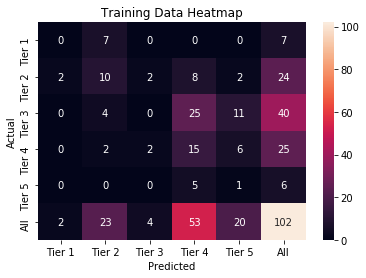

In [165]:
get_heatmap(sgdclf, test_x, test_y)

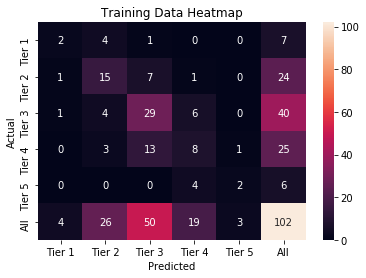

In [166]:
get_heatmap(n_sgdclf, ntest_x, ntest_y)

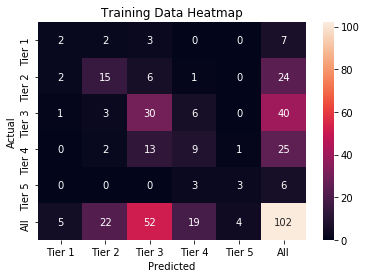

In [167]:
get_heatmap(s_sgdclf, stest_x, stest_y)

### Support Vector Machine (SVM)

In [250]:
from sklearn import svm
nsvma = svm.SVC(C = 1.7, gamma='scale', kernel = "poly", degree = 3)
nsvma.fit(ntrain_x, ntrain_y)
nsvm_score = nsvma.score(ntest_x, ntest_y)
print("Train Score:", nsvma.score(ntrain_x, ntrain_y))
print("Test Score:", nsvm_score)

Train Score: 0.7857142857142857
Test Score: 0.5


In [244]:
svma = svm.SVC(C = 1.7, gamma='scale', kernel = "poly", degree = 3)
svma.fit(strain_x, strain_y)
svm_score = svma.score(stest_x, stest_y)
print("Train Score:", svma.score(strain_x, strain_y))
print("Test Score:", svm_score)

Train Score: 0.8628571428571429
Test Score: 0.4411764705882353


In [175]:
lsvma = svm.LinearSVC()
lsvma.fit(strain_x, strain_y)
lsvm_score = lsvma.score(stest_x, stest_y)
print("Train Score:", lsvma.score(strain_x, strain_y))
print("Test Score:", lsvm_score)

Train Score: 0.6342857142857142
Test Score: 0.5784313725490197


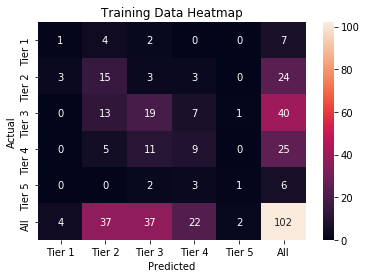

In [176]:
get_heatmap(svma, stest_x, stest_y)

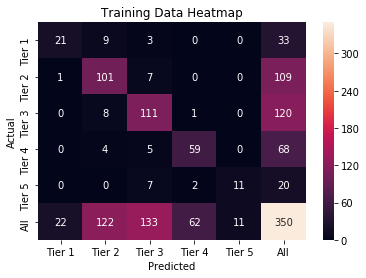

In [177]:
get_heatmap(svma, strain_x, strain_y)

## Prediction Time!

Now is the moment of truth - applying our model to predict where characters will fall on the tier list. There are currently 18 characters in the game that have not been officially tiered on Gamepress.

In [215]:
preds = pd.DataFrame()
preds["Name"] = totest["Name"]
preds.reset_index(drop = "True")

In [224]:
totesta = totest.set_index("Name")
totesta = totesta.drop(["Tier"], axis = 1)
lsvma.predict(totesta)

array(['Tier 1', 'Tier 2', 'Tier 2', 'Tier 1', 'Tier 1', 'Tier 2',
       'Tier 2', 'Tier 1', 'Tier 2', 'Tier 1', 'Tier 2', 'Tier 1',
       'Tier 1', 'Tier 2', 'Tier 1', 'Tier 2', 'Tier 2', 'Tier 1'],
      dtype=object)

In [251]:
nsvma.predict(totesta)

array(['Tier 1', 'Tier 4', 'Tier 2', 'Tier 2', 'Tier 5', 'Tier 2',
       'Tier 2', 'Tier 2', 'Tier 2', 'Tier 1', 'Tier 2', 'Tier 2',
       'Tier 2', 'Tier 2', 'Tier 1', 'Tier 2', 'Tier 2', 'Tier 5'],
      dtype=object)

In [252]:
svma.predict(totesta)

array(['Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1',
       'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1',
       'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1'],
      dtype=object)

In [225]:
preds["Predictions"] = lsvma.predict(totesta)

In [226]:
preds

,Name,Predictions
102,Eyvel,Tier 1
193,Kempf,Tier 2
208,Legendary Celica,Tier 2
249,Mareeta,Tier 1
278,New Year Alfonse,Tier 1
279,New Year Anna,Tier 2
283,New Year Eir,Tier 2
289,New Year Lethe,Tier 1
290,New Year Selkie,Tier 2
309,Osian,Tier 1


There we have it! Our first set of predictions for our model. Granted, there are still things that we can improve and tinker with for the model, as well as information that can be scraped to give our model more to work with. We will have to wait for some time before we can see how right (or wrong) our model is.

With the data that we scraped and the model that we have created, we can also look to answer other common questions related to rolling characters, such as:

* What is the probability of rolling a particular banner character?
* Is it always worth finishing a roll when you get a five-star?
* I don't have that many orbs. Which banner should I burn my orbs on?

We will save our predictions below to compare with the actual tier listing when they come out on gamepress.

In [258]:
# save predictions 
string = "predictions_" + str(datetime.date(datetime.now()))
preds.to_csv(string, encoding='utf-8', index=False)